# Stock trend classification (2.3/3): train InceptionTime

InceptionTime paper:
https://arxiv.org/pdf/1909.04939.pdf

### Load datasets

In [1]:
import numpy as np
import pandas as pd

CLASSES = ['Bull', 'Bear']
LABEL_BULL = CLASSES.index('Bull')
LABEL_BEAR = CLASSES.index('Bear')

datasets = np.load('datasets.npz')
x_train, y_train = datasets['x_train'], datasets['y_train']
x_val, y_val = datasets['x_val'], datasets['y_val']
x_test, y_test = datasets['x_test'], datasets['y_test']

# Label distribution
label_distribution = pd.DataFrame([{'Dataset': 'train',
                                    'Bull': np.count_nonzero(y_train == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_train == LABEL_BEAR)},
                                   {'Dataset': 'val',
                                    'Bull': np.count_nonzero(y_val == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_val == LABEL_BEAR)},
                                   {'Dataset': 'test',
                                    'Bull': np.count_nonzero(y_test == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_test == LABEL_BEAR)}])
label_distribution

,Dataset,Bull,Bear
0,train,827,828
1,val,237,236
2,test,107,107


### Construct model

In [2]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                    BatchNormalization, Activation, \
                                    Add, GlobalAveragePooling1D, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model

def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding='same', activation=None,
                        use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    conv5 = Conv1D(filters=32, kernel_size=5, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    conv7 = Conv1D(filters=32, kernel_size=7, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    mp = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding='same', activation=None,
                          use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mpbottleneck])
    x = BatchNormalization()(x)
    # x = Activation('LeakyReLU')(x)  # Modify there, from relu to LeakyReLU
    x = LeakyReLU(alpha=0.5)(x)
    return x

def shortcut_layer(input_tensor1, input_tendor2):
    shortcut = Conv1D(filters=input_tendor2.shape[-1], kernel_size=1, padding='same',
                      activation=None, use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, input_tendor2])
    # x = Activation('LeakyReLU')(x)  # Modify there, from relu to LeakyReLU
    x = LeakyReLU(alpha=0.1)(x)
    return x

# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer

for i in range(6):
    x = inception_module(x)
    x = Dropout(0.2)(x)  # Modify here, add dropout layer

    if i % 3 == 2:
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

/Users/weilh/Library/Caches/pypoetry/virtualenvs/aistock--dymrmeb-py3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 100, 5)    │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 32)   │      3,072 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 32)   │      5,120 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 100, 32)   │      7,168 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 32)   │        160 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 128)  │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 100, 32)   │      4,096 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 128)  │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 32)   │      3,072 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 32)   │      5,120 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 32)   │      7,168 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 32)   │      4,096 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 128)  │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 154,818 (604.76 KB)

 Trainable params: 152,770 (596.76 KB)

 Non-trainable params: 2,048 (8.00 KB)

### Train model

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_label_counts = label_distribution.iloc[0]  # Add here, add class weight
class_weight = {LABEL_BULL: 1.,
                LABEL_BEAR: train_label_counts['Bull'] / train_label_counts['Bear']}

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, min_lr=0.00001)  # Add here, add callback function
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                   save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
callbacks = [reduce_lr, model_checkpoint, early_stopping]  # Modify here, add callback function

train_history = model.fit(x_train, to_categorical(y_train),
                          class_weight=class_weight,  # Add here, balance the imlance data by using weight
                          validation_data=(x_val, to_categorical(y_val)),
                          batch_size=2048, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5003 - loss: 0.8892 - val_accuracy: 0.4989 - val_loss: 9.4474 - learning_rate: 0.0010
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5003 - loss: 0.7607 - val_accuracy: 0.5011 - val_loss: 4.6490 - learning_rate: 0.0010
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5003 - loss: 0.7055 - val_accuracy: 0.5011 - val_loss: 13.7093 - learning_rate: 0.0010
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5317 - loss: 0.6931 - val_accuracy: 0.5011 - val_loss: 17.0035 - learning_rate: 0.0010
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5003 - loss: 0.7083 - val_accuracy: 0.5011 - val_loss: 14.4101 - learning_rate: 0.0010
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5063 - loss: 0.7140 - val_accuracy: 0.5011 - val_loss: 9.8997 - learning_rate: 0.0010
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5088 - loss: 0.7063 - val_accuracy: 0.50

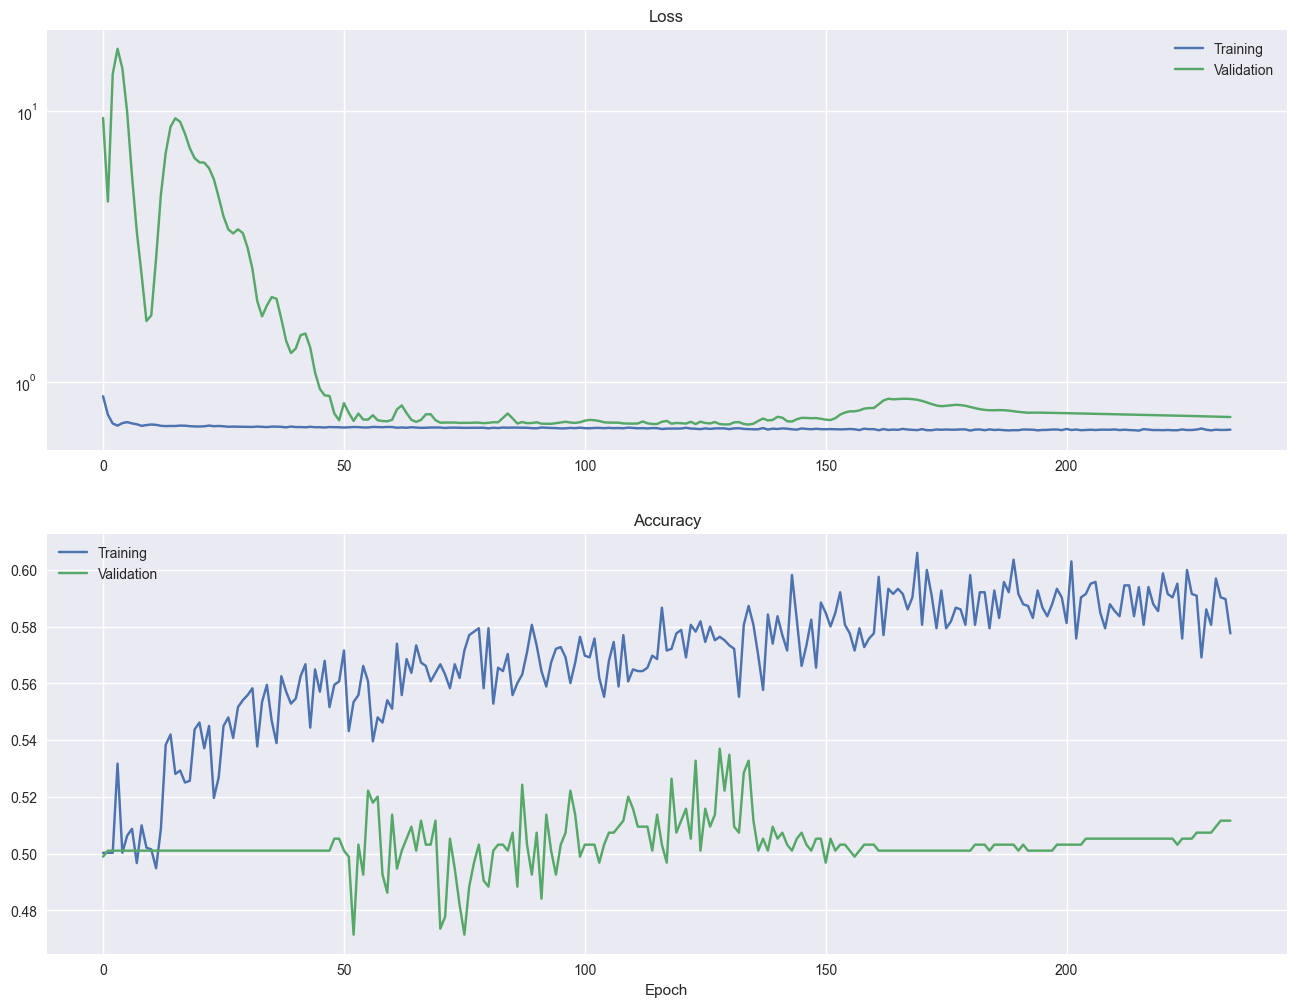

In [4]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[0].plot(train_history.history['loss'], label='Training')
axes[0].plot(train_history.history['val_loss'], label='Validation')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].plot(train_history.history['accuracy'], label='Training')
axes[1].plot(train_history.history['val_accuracy'], label='Validation')
axes[1].legend()